# GenerativeAI4DS-I
## Lab. Video Narration

##  What I hope you'll get out of this lab
* The feeling that you'll "know where to start" when you have to consume OpenAI services.
* Follow OpenAI's best practices on how to process audio and video

In [20]:
!pip install openai

In [21]:
from IPython.display import display, Image, Audio, HTML

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

In [22]:
def show_json(obj):
    display(json.loads(obj.model_dump_json()))

In [23]:
# We need this to load the files onto google colab
!git clone https://github.com/thousandoaks/GenerativeAI4DS-I.git

fatal: destination path 'GenerativeAI4DS-I' already exists and is not an empty directory.


# 1. You have to get your [OpenAI API Key](https://platform.openai.com/account/api-keys)

In [24]:
# Used by the agent in this tutorial
os.environ["OPENAI_API_KEY"] = "YOU-NEED-YOUR-OWN-API"

In [25]:
client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],  # this is also the default, it can be omitted
)

# 2. Video Narration
OpenAI has multimedia processing capabilities. In this example we will create a description of a video.



### 2.1. Frames extraction
#### First, we use OpenCV to extract frames from a nature video

In [26]:
video = cv2.VideoCapture("/content/GenerativeAI4DS-I/datasets/1054733276-preview.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

287 frames read.


#### Display frames to make sure we've read them in correctly:

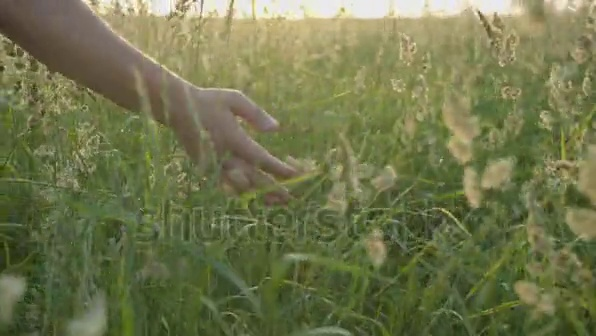

In [27]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

### 2.2. Video Processing
#### Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):

In [33]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Immerse yourself in the serenity of nature with this captivating video. Watch as a hand gently grazes a field of tall, lush grass, each touch evoking a sense of peace and tranquility. The soft light of the setting sun casts a warm glow, enhancing the natural beauty of the scene. Feel the calm and connection to the earth through this simple yet profound moment. Perfect for relaxation and mindfulness, this video invites you to pause and appreciate the quiet wonders of the world around us.


In [34]:
display(HTML(result.choices[0].message.content))


### 2.3 Generating a voiceover for a video with GPT-4 and the TTS API
Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:

In [35]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

"In the heart of the grasslands, a gentle hand extends into the sea of green. The tender caress of human touch against nature's delicate stalks. Here, amidst the verdant expanse, a quiet connection is forged, a reminder of our intrinsic bond with the natural world. Each blade of grass, swaying to the rhythm of the breeze, tells a tale of resilience and harmony. As the sun dips below the horizon, this serene moment encapsulates the timeless dance between humanity and the living, breathing tapestry of the Earth. A dance that has woven together the fabric of life for millennia."


In [36]:
display(HTML(result.choices[0].message.content))

In [37]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "shimmer",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)